# Importing and Loading Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

# Load processed dataset from Task 1
df = pd.read_csv("../data/processed/reviews_processed.csv")

df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play
1,63f63b8b-016a-4262-a27e-f0de9ebf985a,ok,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Butu Mare,0,2,Google Play
2,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,BOA,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play
3,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Tsegaw Fikru,0,85,Google Play
4,f5bfd792-bc81-4d06-99c9-06c7743d3e09,ምንም የማይ ሰራ,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Elsa Tesfay,0,10,Google Play


# Clean Text

In [17]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Detecting which column has the review text
possible_text_cols = ["review", "review_text", "content", "text"]
text_col = None

for col in possible_text_cols:
    if col in df.columns:
        text_col = col
        break

if text_col is None:
    raise ValueError(f"Could not find any text column in df. Available columns: {df.columns.tolist()}")

print("Using text column:", text_col)

df["clean_text"] = df[text_col].apply(clean_text)

df[[text_col, "clean_text"]].sample(10)


Using text column: review_text


,review_text,clean_text
29,"Your application is very irritating to use, so...",your application is very irritating to use som...
833,good,good
223,there is no speed,there is no speed
1626,it is incredible product.,it is incredible product
1202,What do you care about my phone's settings? Wh...,what do you care about my phone s settings who...
1173,why can't I transfer money to telebirr?,why can t i transfer money to telebirr
145,"very uninterested it's not working when the ""d...",very uninterested it s not working when the de...
420,"I am Aimohon Joel , It's can be Good for a Bet...",i am aimohon joel it s can be good for a bette...
535,Is not working both this one and apollo did u ...,is not working both this one and apollo did u ...
894,best,best


# Keywords

## Frequency Based Keywords

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Use the cleaned text
texts = df["clean_text"].tolist()

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(texts)

vocab = count_vec.get_feature_names_out()
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()

freq_df = pd.DataFrame({
    "word": vocab,
    "count": word_counts
})

freq_df = freq_df.sort_values("count", ascending=False)

freq_df.head(20)


,word,count
147,app,730
889,good,288
218,bank,204
259,best,155
224,banking,148
520,dashen,112
2039,use,109
1334,nice,92
1279,mobile,86
1861,super,83


### Visualization 

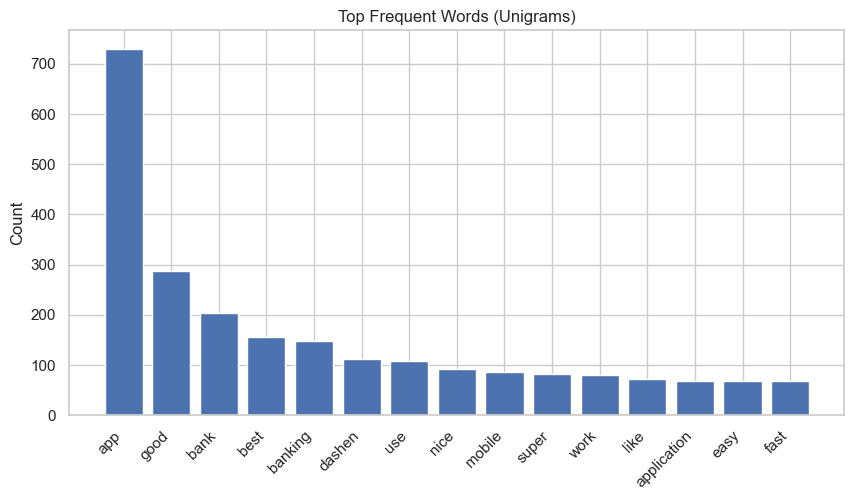

In [19]:
top_n = 15
top_freq = freq_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top Frequent Words (Unigrams)")
plt.ylabel("Count")
plt.show()

## Bigram Keywords Extraction

In [20]:
bigram_vec = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X_bigrams = bigram_vec.fit_transform(texts)

bigrams = bigram_vec.get_feature_names_out()
bigram_counts = np.asarray(X_bigrams.sum(axis=0)).flatten()

bigram_df = pd.DataFrame({
    "bigram": bigrams,
    "count": bigram_counts
}).sort_values("count", ascending=False)

bigram_df.head(20)


,bigram,count
1672,dashen bank,63
3622,mobile banking,61
5127,super app,52
1028,best app,44
916,banking app,41
2682,good app,40
5816,user friendly,34
2034,easy use,34
1944,doesn work,32
3839,nice app,28


### Visualization

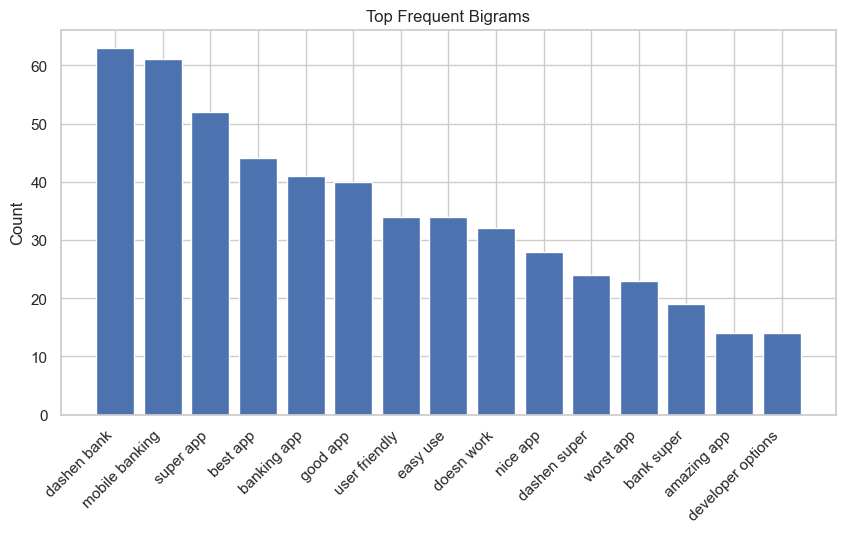

In [21]:
top_n = 15
top_bi = bigram_df.head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(top_bi["bigram"], top_bi["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top Frequent Bigrams")
plt.ylabel("Count")
plt.show()


## TF-IDF Keywords

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

vocab_tfidf = tfidf_vec.get_feature_names_out()
tfidf_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    "word": vocab_tfidf,
    "tfidf": tfidf_scores
}).sort_values("tfidf", ascending=False)

tfidf_df.head(20)


,word,tfidf
889,good,0.114918
147,app,0.079255
259,best,0.050740
1334,nice,0.038774
218,bank,0.023013
1374,ok,0.018698
710,excellent,0.017383
224,banking,0.017321
2147,wow,0.015981
2039,use,0.015582


## Frequency VS TF_IDF

In [23]:
print("Top 15 by raw frequency:")
display(freq_df.head(15))

print("\nTop 15 by TF-IDF (more informative words):")
display(tfidf_df.head(15))


Top 15 by raw frequency:


,word,count
147,app,730
889,good,288
218,bank,204
259,best,155
224,banking,148
520,dashen,112
2039,use,109
1334,nice,92
1279,mobile,86
1861,super,83



Top 15 by TF-IDF (more informative words):


,word,tfidf
889,good,0.114918
147,app,0.079255
259,best,0.050740
1334,nice,0.038774
218,bank,0.023013
1374,ok,0.018698
710,excellent,0.017383
224,banking,0.017321
2147,wow,0.015981
2039,use,0.015582


## TF-IDF per Bank

In [24]:
banks = df["bank_code"].unique()
bank_tfidf = {}

for bank in banks:
    sub = df[df["bank_code"] == bank]

    # Skip if too small
    if len(sub) < 10:
        continue

    vec = TfidfVectorizer(stop_words="english", max_features=3000)
    X = vec.fit_transform(sub["clean_text"])

    vocab = vec.get_feature_names_out()
    scores = np.asarray(X.mean(axis=0)).flatten()

    tmp = pd.DataFrame({"word": vocab, "tfidf": scores})
    tmp = tmp.sort_values("tfidf", ascending=False).head(20)

    bank_tfidf[bank] = tmp
    print(f"\n==== Top TF-IDF words for bank: {bank} ====")
    display(tmp)



==== Top TF-IDF words for bank: BOA ====


,word,tfidf
417,good,0.103244
68,app,0.077460
117,best,0.042561
630,nice,0.026046
126,boa,0.024482
1000,work,0.024340
1003,working,0.022974
98,bank,0.021079
1007,worst,0.019488
102,banking,0.018336



==== Top TF-IDF words for bank: CBE ====


,word,tfidf
378,good,0.160929
69,app,0.087032
120,best,0.055977
562,nice,0.046842
308,excellent,0.026177
584,ok,0.023684
162,cbe,0.021842
108,bank,0.018656
71,application,0.014921
476,like,0.014688



==== Top TF-IDF words for bank: DASHEN ====


,word,tfidf
60,app,0.087362
460,good,0.080854
118,best,0.055467
685,nice,0.044053
248,dashen,0.035181
98,bank,0.034028
970,super,0.030678
387,fast,0.026791
1130,wow,0.025890
100,banking,0.025532


## Topic Modeling (LDA)

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')

# Used CountVectorizer for LDA input
# Reusing the cleaned text
texts = df["clean_text"].tolist()

vectorizer_lda = CountVectorizer(
    stop_words="english",
    max_features=5000,
    max_df=0.95,
    min_df=10  # ignore super-rare words
)
X_lda = vectorizer_lda.fit_transform(texts)

# Fit LDA model with 3 topics
lda_model = LatentDirichletAllocation(
    n_components=4,
    random_state=42,
    learning_method="batch"
)
lda_model.fit(X_lda)

feature_names = vectorizer_lda.get_feature_names_out()

def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n--- Topic {topic_idx + 1} ---")
        top_indices = topic.argsort()[::-1][:n_top_words]
        for i in top_indices:
            print(f"{feature_names[i]:15s}  weight={topic[i]:.4f}")

print_topics(lda_model, feature_names, n_top_words=10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yamis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- Topic 1 ---
app              weight=139.2658
time             weight=67.1500
working          weight=64.2360
like             weight=62.7988
money            weight=52.5461
bank             weight=46.2939
account          weight=37.0910
new              weight=34.9338
wow              weight=34.2460
don              weight=33.2376

--- Topic 2 ---
nice             weight=92.2439
excellent        weight=40.2463
great            weight=38.6827
developer        weight=37.0725
transaction      weight=35.7590
ok               weight=35.2481
boa              weight=33.5645
apps             weight=27.5513
phone            weight=27.2340
bad              weight=26.2412

--- Topic 3 ---
app              weight=362.8373
best             weight=155.2437
banking          weight=84.6008
mobile           weight=83.3458
worst            weight=49.0088
work             weight=47.3344
cbe              weight=46.2258
bank             weight=44.4963
update           weight=36.6817
doesn            w

# Theme

## Keyword Dictionary

In [26]:
theme_keywords = {
    "Account Access & Login Issues": [
        "login", "sign", "password", "verify", "verification",
        "developer", "block", "cannot open", "can't open",
        "doesnt open", "doesn't work", "stuck", "fail", "error"
    ],

    "Transaction Reliability": [
        "transfer", "money", "send", "receive", "transaction",
        "pending", "delay", "charge", "double", "payment", "bill"
    ],

    "App Performance & Stability": [
        "crash", "freeze", "slow", "lag", "bug", "loading",
        "hang", "keeps stopping", "stopped", "doesn't load"
    ],

    "User Interface & Ease of Use": [
        "ui", "interface", "design", "layout", "user friendly",
        "navigate", "navigation", "screen", "button"
    ],

    "Features & Functionality": [
        "feature", "option", "service", "add", "missing", 
        "map", "atm", "agent", "bill"
    ],

    "Positive Experience": [
        "good", "great", "excellent", "nice", "love", 
        "amazing", "best", "super", "fast", "easy"
    ]
}


## Assigning to reviews

In [27]:
import re

def assign_themes_to_review(text, theme_dict):
    text = text.lower()
    matched_themes = []

    for theme, keywords in theme_dict.items():
        for kw in keywords:
            if kw in text:
                matched_themes.append(theme)
                break  # avoid duplicates

    if not matched_themes:
        return ["Uncategorized"]

    return matched_themes

df["themes"] = df["review_text"].apply(
    lambda t: assign_themes_to_review(t, theme_keywords)
)

df[["review_text", "themes"]].head(10)


,review_text,themes
0,good jop,[Positive Experience]
1,ok,[Uncategorized]
2,bad exprience...it is so crushed,[Uncategorized]
3,not user friendly at all it requires a huge co...,"[App Performance & Stability, User Interface &..."
4,ምንም የማይ ሰራ,[Uncategorized]
5,very good,[Positive Experience]
6,most of the time is not working properly,[Uncategorized]
7,good service,"[Features & Functionality, Positive Experience]"
8,not use for me,[Uncategorized]
9,It keeps notifying me to disable developer opt...,"[Account Access & Login Issues, User Interface..."


# Theme

In [28]:
theme_keywords = {
    "Account Access & Login Issues": [
        "login", "sign", "password", "verify", "verification",
        "developer", "block", "cannot open", "can't open",
        "doesnt open", "doesn't work", "stuck", "fail", "error"
    ],

    "Transaction Reliability": [
        "transfer", "money", "send", "receive", "transaction",
        "pending", "delay", "charge", "double", "payment", "bill"
    ],

    "App Performance & Stability": [
        "crash", "freeze", "slow", "lag", "bug", "loading",
        "hang", "keeps stopping", "stopped", "doesn't load"
    ],

    "User Interface & Ease of Use": [
        "ui", "interface", "design", "layout", "user friendly",
        "navigate", "navigation", "screen", "button"
    ],

    "Features & Functionality": [
        "feature", "option", "service", "add", "missing", 
        "map", "atm", "agent", "bill"
    ],

    "Positive Experience": [
        "good", "great", "excellent", "nice", "love", 
        "amazing", "best", "super", "fast", "easy"
    ]
}


In [29]:
import re

def assign_themes_to_review(text, theme_dict):
    text = text.lower()
    matched_themes = []

    for theme, keywords in theme_dict.items():
        for kw in keywords:
            if kw in text:
                matched_themes.append(theme)
                break  # avoid duplicates

    if not matched_themes:
        return ["Uncategorized"]

    return matched_themes

df["themes"] = df["review_text"].apply(
    lambda t: assign_themes_to_review(t, theme_keywords)
)

df[["review_text", "themes"]].head(10)


,review_text,themes
0,good jop,[Positive Experience]
1,ok,[Uncategorized]
2,bad exprience...it is so crushed,[Uncategorized]
3,not user friendly at all it requires a huge co...,"[App Performance & Stability, User Interface &..."
4,ምንም የማይ ሰራ,[Uncategorized]
5,very good,[Positive Experience]
6,most of the time is not working properly,[Uncategorized]
7,good service,"[Features & Functionality, Positive Experience]"
8,not use for me,[Uncategorized]
9,It keeps notifying me to disable developer opt...,"[Account Access & Login Issues, User Interface..."


In [31]:
import os
os.makedirs("../data/processed", exist_ok=True)
df.to_csv("../data/processed/thematic_results.csv", index=False)
print("Saved thematic results to ../data/processed/thematic_results.csv")


Saved thematic results to ../data/processed/thematic_results.csv
